## Scaraping Toronto Neighborhoods Data
### 1. Scrape data from Wikipedia page of Toronto's neighborhoods, and clean the data.

#### Import libraries and display seetings:

In [233]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
pd.set_option('display.max_rows', None)

#### using pandas and BeautifulSoup to scrape the table from the Wiki page of Toronto:

In [234]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
Toronto_df = pd.read_html(str(table))
Toronto_df = Toronto_df[0]   #Toronto_df[0] is the table as a DataFrame
Toronto_df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


#### Drop those rows where borough is 'Not assigned'

In [235]:
#drop those rows where Borough is 'Not assigned'
Toronto_df = Toronto_df.drop(Toronto_df[Toronto_df['Borough']=='Not assigned'].index)
Toronto_df.reset_index(drop=True, inplace=True)
Toronto_df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Check whether each postal code is a unique neighborhood. Answer is no. Some neighborhoods spans multiple postal codes.

In [236]:
print('Total # postal codes: ', Toronto_df['Neighborhood'].size)
print('Total # neighborhoods: ', Toronto_df['Neighborhood'].unique().size)
print('Top 5 neighborhoods with multiple postal codes:')
print(Toronto_df['Neighborhood'].value_counts().head())
Toronto_df[Toronto_df.Neighborhood=='Downsview']

Total # postal codes:  103
Total # neighborhoods:  98
Top 5 neighborhoods with multiple postal codes:
Downsview                            4
Willowdale                           2
Don Mills                            2
Bedford Park, Lawrence Manor East    1
York Mills West                      1
Name: Neighborhood, dtype: int64


,Postal Code,Borough,Neighborhood
40,M3K,North York,Downsview
46,M3L,North York,Downsview
53,M3M,North York,Downsview
60,M3N,North York,Downsview


#### Take care the 'Not assigned' or NaN entries of 'Neighborhood' column

In [237]:
#if Neighborhood is 'Not assigned' or NaN, replace it with the Borough name
try:
    neighborhoodNAList = np.logical_or(Toronto_df['Neighborhood'] == 'Not assigned', Toronto_df['Neighborhood'].isna())
    Toronto_df.loc[neighborhoodNAList, 'Neighborhood'] = Toronto_df.loc[neighborhoodNAList, 'Borough'] 
    if sum(neighborhoodNAList) > 0:
        print('These Neighborhoods names replaced with Borough name:')
        print(Toronto_df[neighborhoodNAList])
    else: 
        print('There are no Neighborhood rows with \'Not assigned\' or empty values.')

except: 
    pass

There are no Neighborhood rows with 'Not assigned' or empty values.


####  Display the number of rows of the dataframe:

In [238]:
print("Number of rows of the dataframe:", Toronto_df.shape[0], '\n') 

Number of rows of the dataframe: 103 



### 2. Get and add latitudes and longitudes to the dataframe:

Using Geocoder Python package to get latitude and longitude coordinates for all postal codes:

In [239]:
#Uncomment the 2 lines below to install geocoder, if it hasn't been installed yet 
#%pip install geocoder
#print('geocoder installed!')

import geocoder # import geocoder
print('geocoder imported!')

# loop until you get the coordinates
for postCode in Toronto_df['Postal Code']:
    print('Postal code: ', postCode)
    i = 1
    maxTrial = 100
    
    latList = []
    lngList = []
   
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postCode))
        #to track progress of trials, since this while loop is because the calls are not reliable
        i = i + 1
        if i % 20 == 0:
            print('Tried ' + str(i) + ' times...')
        #stop trying after predefined # of failed trials, say 100
        if i > maxTrial: 
            break  #if reached max trial, stop trying on this postal code
            
    #try to append the retrieved lat, lng. 
    try:
        lat_lng_coords = g.latlng

        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
        
        latList.append(latitude)
        lngList.append(long)
        
    except:
        print('Failed getting the coordinates after {} trials'.format(maxTrial))
        break  #break out of for loop. Stop the run without throwing exception so that next cell can be run in a batch run case

geocoder imported!
Postal code:  M3A
Tried 20 times...
Tried 40 times...
Tried 60 times...
Tried 80 times...
Tried 100 times...
Failed getting the coordinates after 100 trials


Using the code above, it couldn't get the latitude and longitude coordinates. So will use the data in the csv file provided at this link: http://cocl.us/Geospatial_data and merge it with Toronto_df.

In [240]:
geospatial_data = pd.read_csv('http://cocl.us/Geospatial_data')
Toronto_df = Toronto_df.merge(geospatial_data, left_on='Postal Code', right_on='Postal Code', how='inner') 
Toronto_df.head()


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### 3. Explore and cluster the neighborhoods of Toronto:

In [241]:
#uncomment the 2 lines below if folium is not installed yet
#%pip install folium
#print('folium installed!')

import folium # map rendering library
print('folium imported')

Toronto_lat = Toronto_df['Latitude'].mean()
Toronto_lng = Toronto_df['Longitude'].mean()

# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[Toronto_lat, Toronto_lng], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto_df['Latitude'], 
                                           Toronto_df['Longitude'], 
                                           Toronto_df['Borough'], 
                                           Toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto
 

folium imported


Only work with those boroughs with name "Toronto" in it.

In [242]:
#Toronto_df = Toronto_df[Toronto_df['Borough'].str.contains('Toronto')]
#Toronto_df = Toronto_df.reset_index(drop=True)
#Toronto_df.head()

#### Using Foursqure API to explore the area

In [243]:
CLIENT_ID = 'IWTXQ1HY3TIXMASV3GODHCMKA4EEOVINEXUSDYV5EUPC5RVX' # your Foursquare ID
CLIENT_SECRET = 'C12JHBMT0ZTL0PLAI304G4HVGPZ2KIGU0OV1WMUAZVPUYMLO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


#### Explore the first neighborhood in our dataframe.

In [244]:
Toronto_df.loc[0, 'Neighborhood']

'Parkwoods'

Get the neighborhood's latitude and longitude values.

In [245]:
neighborhood_latitude = Toronto_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Toronto_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = Toronto_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


#### Get the top 100 venues that are in Regent Park, Harbourfront within a radius of 500 meters.

In [246]:
# type your answer here
LIMIT = 100
RADIUS = 500
#search_query = 'Italian'
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION,
    neighborhood_latitude, 
    neighborhood_longitude, 
    RADIUS, 
    LIMIT)
url


'https://api.foursquare.com/v2/venues/explore?client_id=IWTXQ1HY3TIXMASV3GODHCMKA4EEOVINEXUSDYV5EUPC5RVX&client_secret=C12JHBMT0ZTL0PLAI304G4HVGPZ2KIGU0OV1WMUAZVPUYMLO&v=20180605&ll=43.7532586,-79.3296565&radius=500&limit=100'

Send the GET request and examine the resutls

In [247]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eb79131df2774001bb2980e'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 3,
  'suggestedBounds': {'ne': {'lat': 43.757758604500005,
    'lng': -79.32343823984928},
   'sw': {'lat': 43.7487585955, 'lng': -79.33587476015072}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': 

All the information is in the items key. Define get_category_type function:

In [248]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean the json and structure it into a *pandas* dataframe.

In [249]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
print(type(nearby_venues['venue.categories']))

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<class 'pandas.core.series.Series'>


,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Variety Store,Food & Drink Shop,43.751974,-79.333114
2,TTC stop - 44 Valley Woods,Bus Stop,43.755402,-79.333741


Number of venues returned by Foursquare:

In [250]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


### Explore Neighborhoods in Toronto

#### Ceate a function to repeat the same process to all the neighborhoods in Toronto

In [251]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the above function on each neighborhood and create a new dataframe called *Toronto_venues*.

In [294]:
Toronto_venues = getNearbyVenues(names=Toronto_df['Neighborhood'],
                                   latitudes=Toronto_df['Latitude'],
                                   longitudes=Toronto_df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Ri

Check the size of the resulting dataframe:

In [295]:
print(Toronto_venues.shape)
Toronto_venues.head()

(2137, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.753259,-79.329656,TTC stop - 44 Valley Woods,43.755402,-79.333741,Bus Stop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


How many venues returned for each neighborbood:

In [296]:
print('Number of neighborhoods summarized:')
Toronto_venues.groupby('Neighborhood').count().shape[0]


Number of neighborhoods summarized:


96

#### Drop those neighborhoods with too few venues (<1)

In [297]:
s = Toronto_venues['Venue'].value_counts()
Toronto_venues_GT10 = Toronto_venues[Toronto_venues.isin(s.index[s >= 1]).values]
Toronto_venues_GT10.groupby('Neighborhood').count().shape[0]

96

How many unique categories can be curated from all the returned venues:

In [298]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 266 uniques categories.


### Analyze each neighborhood:

In [299]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()
#Toronto_onehot.columns.str.contains('Neighborhood')

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


New dataframe size:

In [300]:
Toronto_onehot.shape

(2137, 266)

Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [301]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Alderwood, Long Branch",0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000
3,Bayview Village,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Bedford Park, Lawrence Manor East",0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Berczy Park,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Birch Cliff, Cliffside West",0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Business reply mail Processing Centre,0.055556,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.125,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Confirm the new size:

In [356]:
Toronto_grouped.shape

(96, 266)

#### Print each neighborhood along with the top 5 most common venues

In [357]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 3})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge  0.25
1               Skating Rink  0.25
2  Latin American Restaurant  0.25
3             Breakfast Spot  0.25
4   Mediterranean Restaurant  0.00


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place   0.2
1             Gym   0.1
2  Sandwich Place   0.1
3             Pub   0.1
4            Pool   0.1


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue   freq
0                       Bank  0.105
1                Coffee Shop  0.105
2        Fried Chicken Joint  0.053
3  Middle Eastern Restaurant  0.053
4                Gas Station  0.053


----Bayview Village----
                 venue  freq
0                 Café  0.25
1                 Bank  0.25
2  Japanese Restaurant  0.25
3   Chinese Restaurant  0.25
4          Yoga Studio  0.00


----Bedford Park, Lawrence Manor East----
                venue   freq
0  Italian Restaurant  0.091
1         Coffee Sh

#### Put it into a *pandas* dataframe

First, define a function to sort the venues in descending order.

In [370]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood.

In [382]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Breakfast Spot,Lounge,Skating Rink,Colombian Restaurant,Comfort Food Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,College Rec Center
1,"Alderwood, Long Branch",Pizza Place,Skating Rink,Sandwich Place,Pharmacy,Pool,Pub,Dance Studio,Coffee Shop,Gym,Gas Station
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Sushi Restaurant,Bridal Shop,Middle Eastern Restaurant,Deli / Bodega,Restaurant,Pizza Place,Pharmacy,Fried Chicken Joint
3,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Grocery Store,Sushi Restaurant,Comfort Food Restaurant,Pharmacy,Pizza Place,Café


### Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into clusters. Experiment of # clusers from 2 to 12 and use 2 metrics, namely, inertia and silhouette score, to gauge the optimal k, which is determined to be 4.

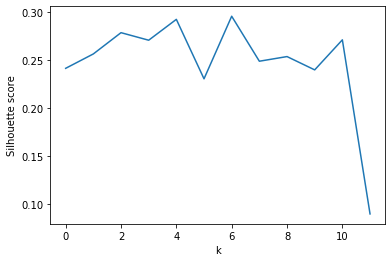

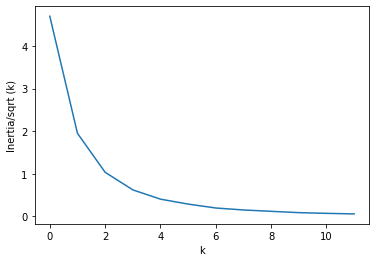

In [383]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
#from sklearn.preprocessing import StandardScaler

# scan number of clusters
kclusters = 12
kmeansInertiaList = []
sScoreList = []
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)
X = Toronto_grouped_clustering #one hotcategorical features no need for feature normalization!
#X = StandardScaler().fit_transform(X)

for k in np.arange(2, kclusters+2):

    # run k-means clustering
    kmeans = KMeans(init='k-means++', n_clusters=k, random_state=0, n_init=12).fit(X)
    
    # check cluster labels generated for each row in the dataframe
    #print(pd.Series(kmeans.labels_).value_counts())
    kmeansInertia = kmeans.inertia_/np.square(k)
    #print('Inertia of the KMeans model (k={}): {}'.format(k, kmeans.inertia_))
    sScore = silhouette_score(X, kmeans.labels_)  #metric for KMeans clustering, peak is best k
    sScoreList.append(sScore)
    kmeansInertiaList.append(kmeansInertia)
    #print('Silhouetter score of the KMeans model (k={}): {}'.format(k, sScore)) 
ax1=plt.figure(1)
plt.plot(np.arange(kclusters), sScoreList,label='Silhouette score')
plt.xlabel('k')
plt.ylabel('Silhouette score')
ax2=plt.figure(2)
plt.plot(np.arange(kclusters), kmeansInertiaList, label='Inertia/sqrt(k)')
plt.xlabel('k')
plt.ylabel('Inertia/sqrt (k)')
plt.show()

Rerun KMeans model using k=3

In [384]:
k = 4
kmeans = KMeans(init='k-means++', n_clusters=k, random_state=0, n_init=12).fit(X)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 3])

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [385]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Toronto_df

# merge Toronto_grouped with Toronto_df to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head() # check the last columns!


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Park,Food & Drink Shop,Bus Stop,College Rec Center,Dance Studio,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,French Restaurant,Coffee Shop,Hockey Arena,Portuguese Restaurant,Dim Sum Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Park,Pub,Bakery,Café,Theater,Restaurant,Breakfast Spot,Yoga Studio,Event Space
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Clothing Store,Accessories Store,Event Space,Shoe Store,Vietnamese Restaurant,Miscellaneous Shop,Coffee Shop,Boutique,Arts & Crafts Store,Furniture / Home Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,Coffee Shop,Sushi Restaurant,Burger Joint,Bar,Beer Bar,Italian Restaurant,Juice Bar,Sandwich Place,Distribution Center,Restaurant


Visualize the resulting clusters.

In [386]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[Toronto_lat , Toronto_lng ], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#drop those rows with NaN or NA
Toronto_merged = Toronto_merged.dropna()

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine clusters
#### Cluster 1 (code below shows parks  are most common for this clsuter)

In [387]:
a = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]
a.describe(include='object')

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,10,10,10,10,10,10,10,10,10,10,10
unique,7,1,10,8,6,7,7,7,7,6,5
top,North York,Park,Pool,Convenience Store,Discount Store,Deli / Bodega,Eastern European Restaurant,Dessert Shop,Donut Shop,Distribution Center,Diner
freq,3,10,1,2,4,2,2,2,2,3,3


Cluster 1 is more park oriented.

#### Cluster 2 (code below shows coffe shops are most common for this cluster)

In [388]:
a = Toronto_merged.loc[Toronto_merged['Cluster Labels'] ==1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]
a.describe(include='object')


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,88,88,88,88,88,88,88,88,88,88,88
unique,10,38,48,48,53,53,51,50,47,46,51
top,North York,Coffee Shop,Coffee Shop,Coffee Shop,Bank,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Discount Store,Dim Sum Restaurant
freq,20,19,13,6,5,6,7,9,11,11,5


Cluster 2 clearly has lots of coffee shops!

In [389]:
a = Toronto_merged.loc[Toronto_merged['Cluster Labels'] ==2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]
a.describe(include='object')


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,2,2,2,2,2,2,2,2,2,2,2
unique,2,2,2,2,2,1,1,1,1,1,1
top,Central Toronto,Convenience Store,Playground,Discount Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
freq,1,1,1,1,1,2,2,2,2,2,2


In [390]:
a = Toronto_merged.loc[Toronto_merged['Cluster Labels'] ==3, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]
a.describe(include='object')


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1
top,North York,Cafeteria,Women's Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center,Curling Ice
freq,1,1,1,1,1,1,1,1,1,1,1


In [391]:
a = [i for i in 'abaaafgddddddnopqrstuvwxyz']
b = [i for i in range(26)]
c = [i*2 for i in range(26)]
d = pd.DataFrame(zip(a,b,c))
d.columns = ['a', 'b', 'c']
e = d.groupby('a').count().reset_index()
e

,a,b,c
0,a,4,4
1,b,1,1
2,d,6,6
3,f,1,1
4,g,1,1
5,n,1,1
6,o,1,1
7,p,1,1
8,q,1,1
9,r,1,1


In [392]:
len(a)

26